![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)

# Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Gabriel Iturra, Ignacio Meza De La Jara
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

_Por favor, lean detalladamente las instrucciones de la tarea antes de empezar a escribir._

---

## Reglas

- Fecha de entrega: 19/12/2023
- **Grupos de 2 personas.**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Estrictamente prohibida la copia.
- Pueden usar cualquier material del curso que estimen conveniente.

---

### Integrantes:
- Nicolás Acevedo
- Fabiola Pizarro

### **Link de repositorio de GitHub:** `https://github.com/nicoacevedor/MDS7202`


# Presentación del Problema


![](https://www.diarioeldia.cl/u/fotografias/fotosnoticias/2019/11/8/67218.jpg)


**Giturra**, un banquero astuto y ambicioso, estableció su propio banco con el objetivo de obtener enormes ganancias. Sin embargo, su reputación se vio empañada debido a las tasas de interés usureras que imponía a sus clientes. A medida que su banco crecía, Giturra enfrentaba una creciente cantidad de préstamos impagados, lo que amenazaba su negocio y su prestigio.

Para abordar este desafío, Giturra reconoció la necesidad de reducir los riesgos de préstamo y mejorar la calidad de los préstamos otorgados. Decidió aprovechar la ciencia de datos y el análisis de riesgo crediticio. Contrató a un equipo de expertos para desarrollar un modelo predictivo de riesgo crediticio.

Cabe señalar que lo modelos solicitados por el banquero deben ser interpretables. Ya que estos le permitira al equipo comprender y explicar cómo se toman las decisiones crediticias. Utilizando visualizaciones claras y explicaciones detalladas, pudieron identificar las características más relevantes, le permitirá analizar la distribución de la importancia de las variables y evaluar si los modelos son coherentes con el negocio.

Para esto Giturra les solicita crear un modelo de riesgo disponibilizandoles una amplia gama de variables de sus usuarios: como historiales de crédito, ingresos y otros factores financieros relevantes, para evaluar la probabilidad de incumplimiento de pago de los clientes. Con esta información, Giturra podra tomar decisiones más informadas en cuanto a los préstamos, ofreciendo condiciones más favorables a aquellos con menor riesgo de impago.


### Introducción

blablabla

### Importación de librerías a utilizar

In [121]:
from lightgbm import LGBMClassifier
import optuna
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Configuraciones generales del proyecto

In [122]:
random_state = 42
train_size = 0.7
val_size = 0.2

### Análisis exploratiorio de los datos

In [123]:
df_raw = pd.read_parquet("dataset.pq")
print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               12500 non-null  object 
 1   age                       12500 non-null  float64
 2   occupation                12500 non-null  object 
 3   annual_income             12500 non-null  float64
 4   monthly_inhand_salary     10584 non-null  float64
 5   num_bank_accounts         12500 non-null  int64  
 6   num_credit_card           12500 non-null  int64  
 7   interest_rate             12500 non-null  int64  
 8   num_of_loan               12500 non-null  float64
 9   delay_from_due_date       12500 non-null  int64  
 10  num_of_delayed_payment    11660 non-null  float64
 11  changed_credit_limit      12246 non-null  float64
 12  num_credit_inquiries      12243 non-null  float64
 13  outstanding_debt          12500 non-null  float64
 14  credit

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0


In [124]:
df_raw['credit_score'].value_counts(normalize=True)

credit_score
0    0.71184
1    0.28816
Name: proportion, dtype: float64

### 3. Preparación de Datos

In [125]:
# Limpieza
df = df_raw.copy()
# Edad entre 14 y 100
df = df[(df['age'] >= 14) & (df['age'] <= 100)]
# interés máximo de 100%
df = df[df['interest_rate'] <= 100]
# eliminar valores negativos
df = df[df['num_of_loan'] >= 0]
df = df[df['num_bank_accounts'] >= 0]
df = df[df['delay_from_due_date'] >= 0]
df = df[df['num_of_delayed_payment'] >= 0]
# la borré porque creo que no sirve pal proyecto
df = df.drop(columns=['customer_id'])

In [126]:
df.shape

(10528, 21)

#### 3.1 Preprocesamiento con `ColumnTransformer`

In [127]:
# Se cambian los tipos de datos
df['age'] = df['age'].astype('int64')
df['num_of_loan'] = df['num_of_loan'].astype('int64')
df['delay_from_due_date'] = df['delay_from_due_date'].astype('float64')

In [128]:
# Se divide el DataFrame en características (X) y variable objetivo (y)
X = df.drop(["credit_score"], axis=1)
y = df["credit_score"]

# Definición de variables categóricas y numéricaas
categorical_cols = ['occupation', 'payment_of_min_amount', 'payment_behaviour']
numeric_cols = list(set(X.columns) - (set(categorical_cols)))

# ColumnTransformer
scaler = ColumnTransformer([
    ("NumericScaler", MinMaxScaler(), numeric_cols),
    ("CategoricalEncoder", OneHotEncoder(sparse_output=False), categorical_cols)
], remainder="passthrough")
scaler.set_output(transform='pandas')

# Se prueban las transformaciones
X_preprocessed = scaler.fit_transform(X)

#### 3.2 Holdout 

In [129]:
def split_data(X, y, train_size, val_size):
    X_train, X_med, y_train, y_med = train_test_split(
        X, y, train_size=train_size, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_med, y_med, train_size=val_size / (1 - train_size), random_state=random_state
    )
    return (
        X_train,
        X_val,
        X_test,
        y_train,
        y_val,
        y_test
    )

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=train_size, val_size=val_size)

#### 3.3 Datos nulos

In [130]:
porcentajes_nulos = (df.isnull().sum() / len(df))
porcentajes_nulos = porcentajes_nulos[porcentajes_nulos > 0].sort_values(ascending=False)
print("Columnas con valores nulos [%]")
print("------------------------------")
porcentajes_nulos

Columnas con valores nulos [%]
------------------------------


monthly_inhand_salary      0.152451
credit_history_age         0.088526
amount_invested_monthly    0.046922
monthly_balance            0.028210
num_credit_inquiries       0.020802
changed_credit_limit       0.020327
dtype: float64

### 4 Baseline

In [131]:
# Imputador
imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant'))
])

def create_pipeline(scaler, model):
    pipeline = Pipeline([
        ("scaler", scaler),
        ('imputer', imputer),
        ("model", model)
    ])
    return pipeline

all_models = {
    "dummy": DummyClassifier(strategy="stratified", random_state=random_state),
    "logistic_reg": LogisticRegression(random_state=random_state),
    "k_neighbors": KNeighborsClassifier(),
    "decision_tree": DecisionTreeClassifier(random_state=random_state),
    "svc": SVC(random_state=random_state),
    "random_forest": RandomForestClassifier(random_state=random_state),
    "lgbm": LGBMClassifier(random_state=random_state, verbose=-1),
    "xgb": XGBClassifier(random_state=random_state),
}

### Entrenamiento de los modelos

In [132]:
recall_by_model = {}

for name, model in all_models.items():
    print(name)
    pipeline = create_pipeline(scaler, model)
    display(pipeline.fit(X_train, y_train))
    y_pred = pipeline.predict(X_test)
    cr = classification_report(y_test, y_pred, output_dict=True)
    recall_by_model[name] = cr['1']['recall']
    print(f"Classification Report '{name}'")
    print(classification_report(y_test, y_pred), '\n')

dummy


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',
                                                   'delay_from_due_date',
                                                   'num_credit_inquiries',
                                                   'monthly_balance',
                                                   'monthly_inhand_salary',
                                                   'num_credit_card']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

Classification Report 'dummy'
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       732
           1       0.29      0.27      0.28       321

    accuracy                           0.58      1053
   macro avg       0.49      0.49      0.49      1053
weighted avg       0.57      0.58      0.57      1053
 

logistic_reg


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',
                                                   'delay_from_due_date',
                                                   'num_credit_inquiries',
                                                   'monthly_balance',
                                                   'monthly_inhand_salary',
                                                   'num_credit_card']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', LogisticRegression(random_state=42))])

Classification Report 'logistic_reg'
              precision    recall  f1-score   support

           0       0.77      0.92      0.83       732
           1       0.66      0.36      0.47       321

    accuracy                           0.75      1053
   macro avg       0.71      0.64      0.65      1053
weighted avg       0.73      0.75      0.72      1053
 

k_neighbors


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',
                                                   'delay_from_due_date',
                                                   'num_credit_inquiries',
                                                   'monthly_balance',
                                                   'monthly_inhand_salary',
                                                   'num_credit_card']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', KNeighborsClassifier())])

Classification Report 'k_neighbors'
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       732
           1       0.55      0.41      0.47       321

    accuracy                           0.72      1053
   macro avg       0.66      0.63      0.64      1053
weighted avg       0.70      0.72      0.70      1053
 

decision_tree


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',
                                                   'delay_from_due_date',
                                                   'num_credit_inquiries',
                                                   'monthly_balance',
                                                   'monthly_inhand_salary',
                                                   'num_credit_card']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', DecisionTreeClassifier(random_state=42))])

Classification Report 'decision_tree'
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       732
           1       0.50      0.48      0.49       321

    accuracy                           0.70      1053
   macro avg       0.64      0.64      0.64      1053
weighted avg       0.69      0.70      0.70      1053
 

svc


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',
                                                   'delay_from_due_date',
                                                   'num_credit_inquiries',
                                                   'monthly_balance',
                                                   'monthly_inhand_salary',
                                                   'num_credit_card']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', SVC(random_state=42))])

Classification Report 'svc'
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       732
           1       0.66      0.39      0.49       321

    accuracy                           0.75      1053
   macro avg       0.72      0.65      0.66      1053
weighted avg       0.74      0.75      0.73      1053
 

random_forest


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',
                                                   'delay_from_due_date',
                                                   'num_credit_inquiries',
                                                   'monthly_balance',
                                                   'monthly_inhand_salary',
                                                   'num_credit_card']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', RandomForestClassifier(random_state=42))])

Classification Report 'random_forest'
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       732
           1       0.66      0.50      0.56       321

    accuracy                           0.77      1053
   macro avg       0.73      0.69      0.70      1053
weighted avg       0.76      0.77      0.76      1053
 

lgbm


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',
                                                   'delay_from_due_date',
                                                   'num_credit_inquiries',
                                                   'monthly_balance',
                                                   'monthly_inhand_salary',
                                                   'num_credit_card']),
                                                 ('CategoricalEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])])),
                ('imputer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='constant'))])),
                ('model', LGBMClassifier(random_state=42, verbose=-1))])

Classification Report 'lgbm'
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       732
           1       0.64      0.55      0.60       321

    accuracy                           0.77      1053
   macro avg       0.73      0.71      0.72      1053
weighted avg       0.76      0.77      0.77      1053
 

xgb


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Classification Report 'xgb'
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       732
           1       0.62      0.51      0.56       321

    accuracy                           0.76      1053
   macro avg       0.71      0.69      0.70      1053
weighted avg       0.75      0.76      0.75      1053
 



### Evaluación de los clasificadores

In [133]:
recall_df = pd.DataFrame(recall_by_model.items(), columns=['Model', 'Recall'])
recall_df.sort_values('Recall', ascending=False, inplace=True)
recall_df

,Model,Recall
6,lgbm,0.554517
7,xgb,0.510903
5,random_forest,0.495327
3,decision_tree,0.476636
2,k_neighbors,0.408100
4,svc,0.389408
1,logistic_reg,0.361371
0,dummy,0.271028


### 5. Optimización del modelo

In [134]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(
        trial: optuna.Trial, 
        model,
        data, 
        target, 
        scaler, 
        random_seed=random_state
):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': random_seed,
    }
    if isinstance(model, LGBMClassifier):
        params['verbose'] = -1
    X_train, X_val, _, y_train, y_val, _ = split_data(data, target, train_size=0.7, val_size=0.2)
    instanciated_model = model(**params)
    pipeline = create_pipeline(scaler, instanciated_model)
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)
    return recall_score(y_val, y_pred, average="binary")


#### Optimización de `LGBMClassifier`

In [135]:
study_lgbm = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=random_state),
    direction='maximize',
    study_name="lgbm_opt"
)  

study_lgbm.optimize(
    lambda trial: objective(trial, LGBMClassifier, X, y, scaler, random_state),
    timeout=5*60,
    show_progress_bar=True
) 

   0%|          | 00:00/05:00

[LightGBM] [Warning] num_leaves is set=31, max_leaves=60 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_leaves is set=31, max_leaves=60 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2147, number of negative: 5222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 7369, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291356 -> initscore=-0.888809
[LightGBM] [Info] Start training from score -0.888809
[LightGBM] [Warning] num_leaves is set=31, 

In [136]:
print(f"Mejor Recall: {study_lgbm.best_value:.3f}")

print("\nMejores parámetros: \n--------------------")
for param, value in study_lgbm.best_params.items():
    print(f"{param}: {value:.3f}")

Mejor Recall: 0.550

Mejores parámetros: 
--------------------
learning_rate: 0.092
n_estimators: 97.000
max_depth: 8.000
max_leaves: 76.000
min_child_weight: 5.000
reg_alpha: 0.063
reg_lambda: 0.258


#### Optimización de `XGBoostClassifier`

In [137]:
study_xgb = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=random_state),
    direction='maximize',
    study_name="lgbm_opt"
)  

study_xgb.optimize(
    lambda trial: objective(trial, XGBClassifier, X, y, scaler, random_state),
    timeout=5*60,
    show_progress_bar=True
) 

   0%|          | 00:00/05:00

In [138]:
print(f"Mejor Recall: {study_xgb.best_value:.3f}")

print("\nMejores parámetros: \n--------------------")
for param, value in study_xgb.best_params.items():
    print(f"{param}: {value:.3f}")

Mejor Recall: 0.555

Mejores parámetros: 
--------------------
learning_rate: 0.089
n_estimators: 90.000
max_depth: 8.000
max_leaves: 96.000
min_child_weight: 3.000
reg_alpha: 0.653
reg_lambda: 0.023


### 6. Interpretabilidad

In [139]:
predictor = XGBClassifier(random_seed=random_state, **study_xgb.best_params)

optimized_pipeline = Pipeline([
    ("scaler", scaler),
    ('imputer', imputer),
    ("model", predictor)
])

optimized_pipeline.fit(X_train, y_train)

[15:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "random_seed" } are not used.



Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumericScaler',
                                                  MinMaxScaler(),
                                                  ['total_emi_per_month',
                                                   'num_of_delayed_payment',
                                                   'credit_utilization_ratio',
                                                   'num_of_loan',
                                                   'num_bank_accounts',
                                                   'outstanding_debt',
                                                   'interest_rate',
                                                   'annual_income',
                                                   'credit_history_age',
                                                   'changed_credit_limit',
                                                   'age',
                                                   'amount_invested_monthly',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.08903078301895714, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8, max_leaves=96,
                               min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=90, n_jobs=None,
                               num_parallel_tree=None, random_seed=42, ...))])

In [140]:
# Primero se obtiene la importancia de las características
feature_importance_weight = predictor.get_booster().get_score(importance_type='weight')
feature_importance_cover = predictor.get_booster().get_score(importance_type='cover')
feature_importance_gain = predictor.get_booster().get_score(importance_type='gain')

column_names = X_train.columns
# Luego se redondea y se colocan los nombres de las columnas
rounded_weight = {key: np.round(val, 2) for key, val in feature_importance_weight.items()}
rounded_cover = {key: np.round(val, 2) for key, val in feature_importance_cover.items()}
rounded_gain = {key: np.round(val, 2) for key, val in feature_importance_gain.items()}

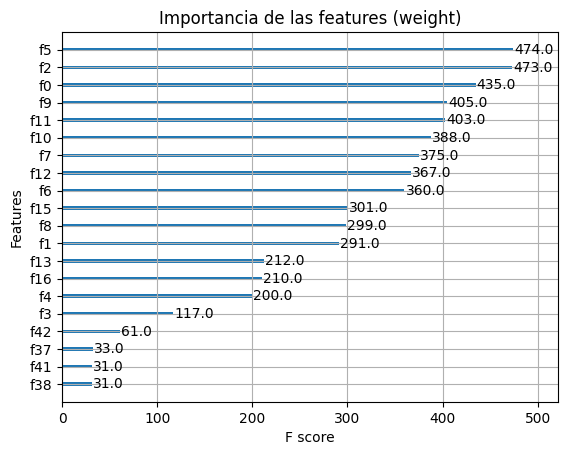

In [141]:
# Gráfico para weight
xgb.plot_importance(rounded_weight, max_num_features=20)
plt.title("Importancia de las features (weight)")
plt.show()

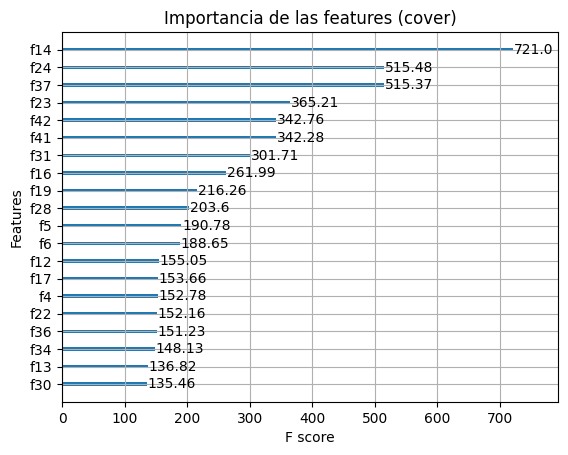

In [142]:
# Gráfico para cover
xgb.plot_importance(rounded_cover, max_num_features=20)
plt.title("Importancia de las features (cover)")
plt.show()

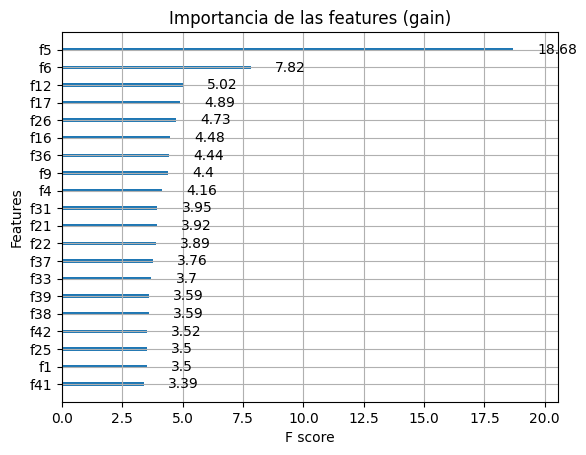

In [143]:
# Gráfico para gain
xgb.plot_importance(rounded_gain, max_num_features=20)
plt.title("Importancia de las features (gain)")
plt.show()

In [144]:
# Se calculan los resultados
result = permutation_importance(optimized_pipeline, X_test, y_test, n_repeats=30, random_state=random_state)
result

{'importances_mean': array([-6.48939538e-03, -3.16555872e-04,  1.99430199e-03, -2.24754669e-03,
         1.06362773e-02, -3.22886990e-03,  4.78315923e-02,  2.50079139e-03,
         4.92877493e-02,  1.00031656e-02,  1.17125673e-02, -2.22044605e-17,
         3.98860399e-02, -7.59734093e-04,  1.10161443e-02,  1.42450142e-03,
        -1.45615701e-03,  6.33111744e-04, -3.16555872e-05,  3.16555872e-05]),
 'importances_std': array([0.00381512, 0.0025046 , 0.00214255, 0.00399526, 0.00505737,
        0.00243481, 0.01027364, 0.00264641, 0.00486313, 0.0041303 ,
        0.00558791, 0.00274145, 0.00838724, 0.00245693, 0.00761947,
        0.00179769, 0.00418812, 0.0040613 , 0.00363268, 0.00038641]),
 'importances': array([[-0.00569801, -0.01139601, -0.00664767, -0.00664767, -0.00474834,
         -0.00189934, -0.00379867, -0.01139601, -0.002849  ,  0.00094967,
         -0.01139601, -0.00664767, -0.00379867, -0.00474834, -0.00569801,
         -0.01424501, -0.00949668, -0.00379867, -0.01139601, -0.0066

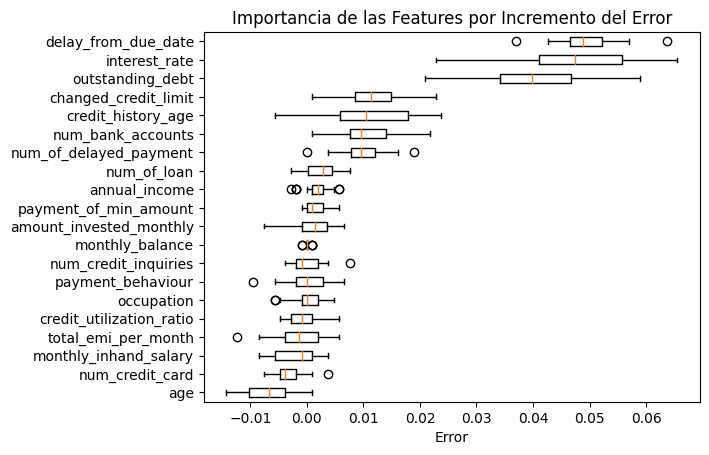

In [145]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx]
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

In [146]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [147]:
X_scaler = scaler.fit_transform(X)
X_preprocessed = imputer.fit_transform(X_scaler)

explainer = shap.TreeExplainer(predictor)
shap_values = explainer(X_preprocessed)
shap_values

[15:16:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


.values =
array([[-1.6632654e-02,  6.5192662e-02,  3.3547789e-02, ...,
         1.8467378e-03, -2.8529547e-02, -3.8947444e-02],
       [-4.0828321e-02,  2.5947830e-01,  1.2959361e-02, ...,
         1.0851524e-03, -6.3652610e-03,  1.9358979e-01],
       [-1.5377027e-01,  9.3587399e-02,  1.0854646e-02, ...,
        -3.3014757e-03, -2.8241146e-02,  1.6494958e-02],
       ...,
       [ 8.1848197e-02,  1.7699511e-01,  2.6598696e-02, ...,
        -1.0683601e-03, -1.5256055e-02, -1.3786538e-01],
       [-4.3442480e-02, -9.7815014e-02, -5.0445992e-02, ...,
         3.0059280e-04, -6.3504413e-02, -4.8194043e-02],
       [ 9.5675305e-02,  6.7799288e-01, -2.6209848e-02, ...,
         6.1254106e-03, -4.0556587e-02, -1.1041699e-01]], dtype=float32)

.base_values =
array([-0.9214023, -0.9214023, -0.9214023, ..., -0.9214023, -0.9214023,
       -0.9214023], dtype=float32)

.data =
array([[6.04786439e-04, 1.42314991e-03, 1.31982576e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    

Aporte de las variables para la instancia 1


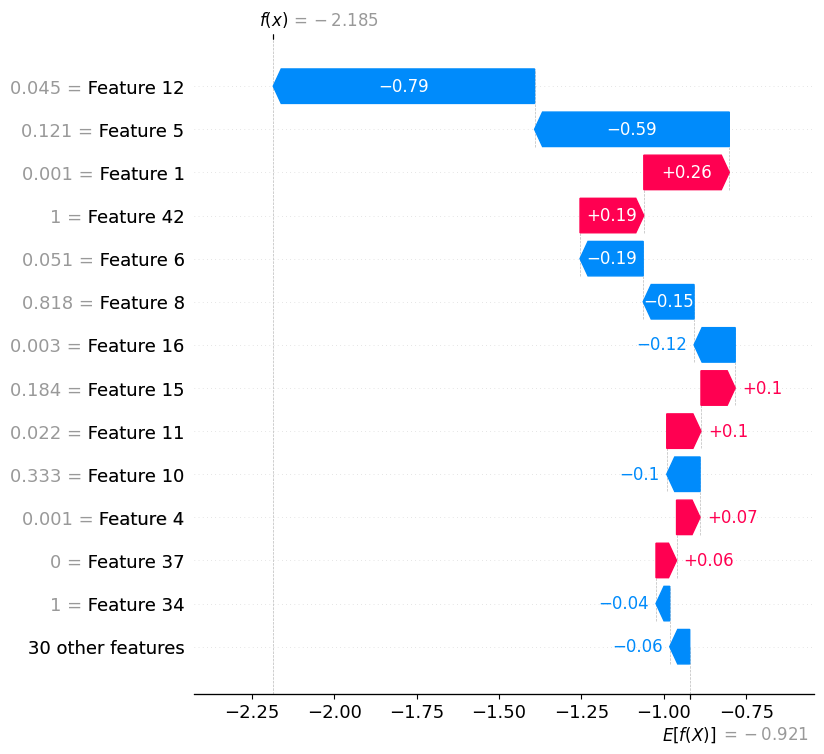

Aporte de las variables para la instancia 9


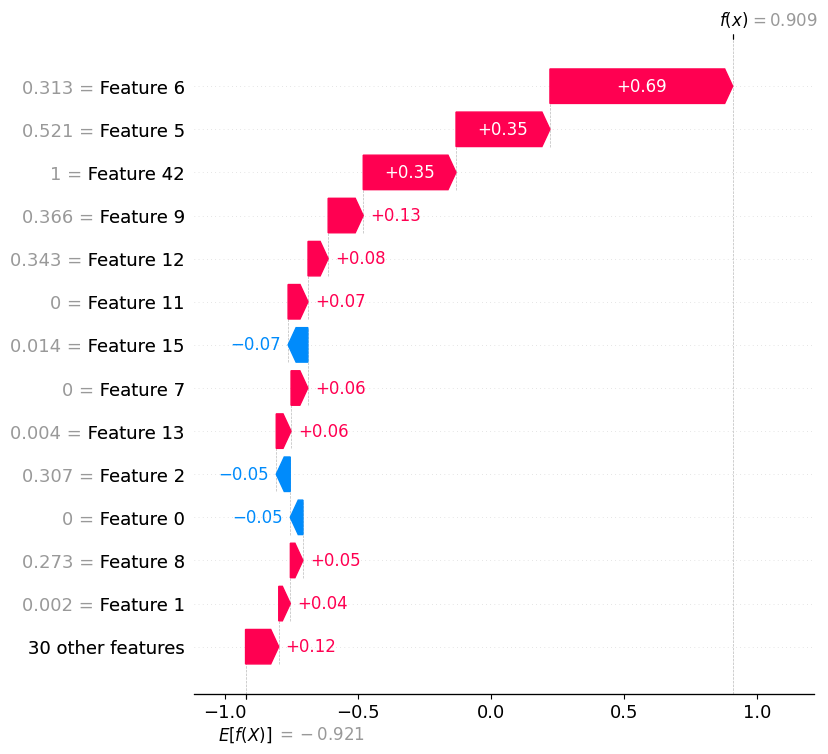

Aporte de las variables para la instancia 150


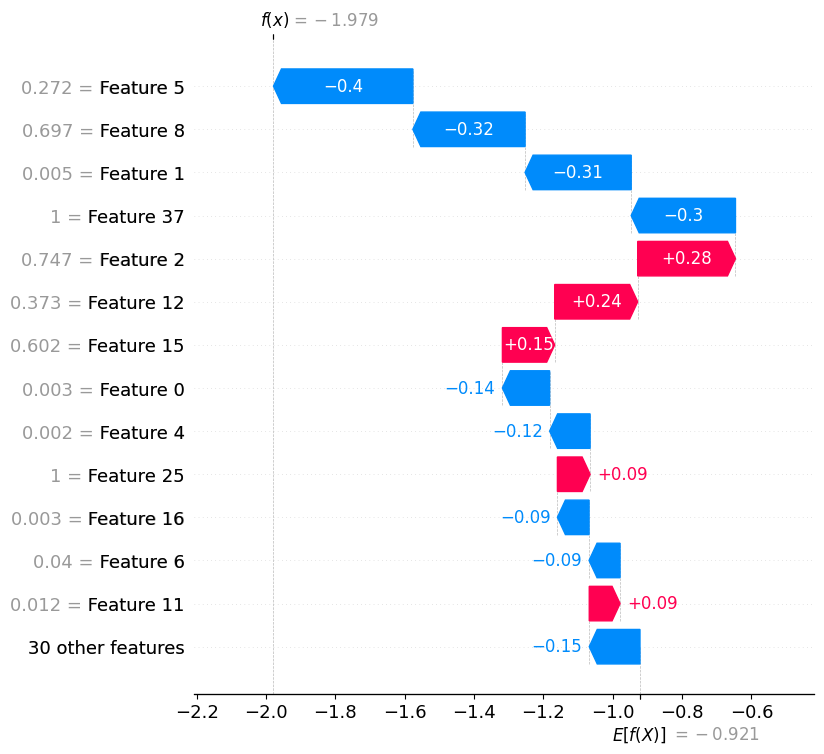

In [148]:
instancias = [1, 9, 150]

for i in instancias:
    print(f"Aporte de las variables para la instancia {i}")
    shap.plots.waterfall(shap_values[i], max_display=14)

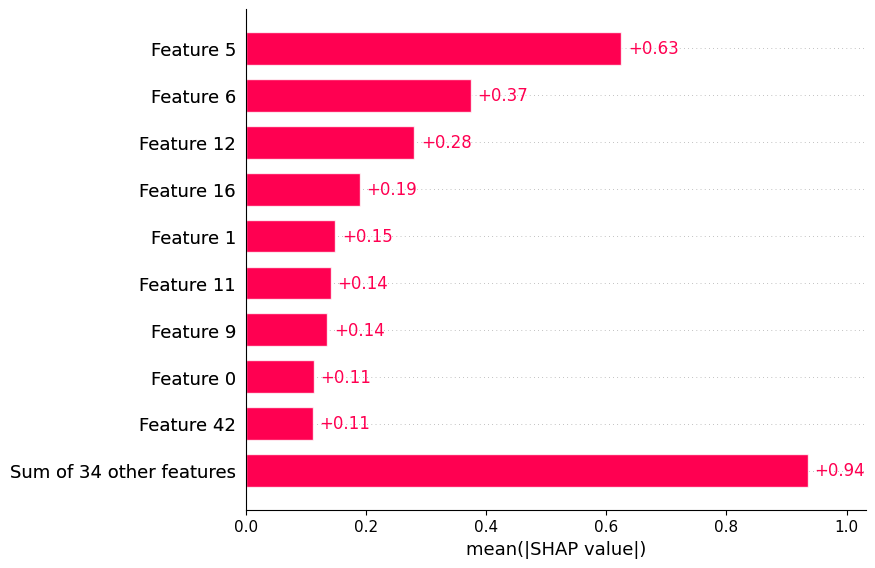

In [149]:
shap.plots.bar(shap_values)